# Create Cases in Batch and Run in Parallel

This notebook demonstrates creating cases in batch and running them in parallel.

## Create Cases in Batch

The approach to create cases in batch following this procedure:

- Load the base case from file
- For each desired case output:
  * Alter parameters to the desired value
  * Save each system to a new case file

In [1]:
import andes
import numpy as np
from andes.utils.paths import get_case

andes.config_logger(stream_level=30)  # brief logging

In [2]:
# create directory for output cases
!rm -rf batch_cases
!mkdir -p batch_cases

In [3]:
kundur = get_case('kundur/kundur_full.xlsx')
ss = andes.load(kundur)

We demonstrate running the Kundur's system under different loading conditions.

Cases are created by modifying the `p0` of `PQ` with `idx == PQ_0`.

As always, input parameters can be inspected by accessing `Model.as_df(vin=True)`. 

In [4]:
p0_base = ss.PQ.get('p0', "PQ_0")

Create 3 cases so that the load increases from `p0_base` to `1.2 * p0_base`.

In [5]:
N_CASES = 3  # Note: increase `N_CASES` as necessary

p0_values = np.linspace(p0_base, 1.2 * p0_base, N_CASES)

In [6]:
for value in p0_values:
    ss.PQ.alter('p0', 'PQ_0', value)
    file_name = f'batch_cases/kundur_p_{value:.2f}.xlsx'
    
    andes.io.dump(ss, 'xlsx', file_name, overwrite=True)

## Parallel Simulation

Parallel simulation is easy with the command line tool.

Change directory to `batch_cases`:

In [7]:
import os

# change the Python working directory
os.chdir('batch_cases')

In [8]:
!ls -la

total 56
drwxr-xr-x 2 hcui7 hcui7  4096 Oct  6 09:05 .
drwxr-xr-x 6 hcui7 hcui7  4096 Oct  6 09:05 ..
-rw-r--r-- 1 hcui7 hcui7 14640 Oct  6 09:05 kundur_p_11.59.xlsx
-rw-r--r-- 1 hcui7 hcui7 14641 Oct  6 09:05 kundur_p_12.75.xlsx
-rw-r--r-- 1 hcui7 hcui7 14640 Oct  6 09:05 kundur_p_13.91.xlsx


### Running from Command line

In [9]:
!andes run *.xlsx -r tds


    _           _         | Version 1.4.3.post11.dev0+g66add67d
   /_\  _ _  __| |___ ___ | Python 3.9.6 on Linux, 10/06/2021 09:05:44 AM
  / _ \| ' \/ _` / -_|_-< | 
 /_/ \_\_||_\__,_\___/__/ | This program comes with ABSOLUTELY NO WARRANTY.

Working directory: "/home/hcui7/repos/andes/examples/batch_cases"
-> Processing 3 jobs on 32 CPUs.
Process 0 for "kundur_p_11.59.xlsx" started.
Process 1 for "kundur_p_12.75.xlsx" started.
Process 2 for "kundur_p_13.91.xlsx" started.
<Toggler 1>: Line.Line_8 status changed to 0 at t=2.0 sec.
<Toggler 1>: Line.Line_8 status changed to 0 at t=2.0 sec.
<Toggler 1>: Line.Line_8 status changed to 0 at t=2.0 sec.
Log saved to "/tmp/andes/andes-kpztgyvw/andes.log".
-> Multiprocessing finished in 1.2183 seconds.


### Number of CPUs

In some cases, you don't want the simulatino to use up all resources. 

ANDES allows to control the number of processes to run in parallel through `--ncpu NCPU`, where `NCPU` is the maximum number of processes (equivalent to the number of CPU cores) allowed. 

In [10]:
!andes run *.xlsx -r tds --ncpu 4


    _           _         | Version 1.4.3.post11.dev0+g66add67d
   /_\  _ _  __| |___ ___ | Python 3.9.6 on Linux, 10/06/2021 09:05:45 AM
  / _ \| ' \/ _` / -_|_-< | 
 /_/ \_\_||_\__,_\___/__/ | This program comes with ABSOLUTELY NO WARRANTY.

Working directory: "/home/hcui7/repos/andes/examples/batch_cases"
-> Processing 3 jobs on 4 CPUs.
Process 0 for "kundur_p_11.59.xlsx" started.
Process 1 for "kundur_p_12.75.xlsx" started.
Process 2 for "kundur_p_13.91.xlsx" started.
<Toggler 1>: Line.Line_8 status changed to 0 at t=2.0 sec.
<Toggler 1>: Line.Line_8 status changed to 0 at t=2.0 sec.
<Toggler 1>: Line.Line_8 status changed to 0 at t=2.0 sec.
Log saved to "/tmp/andes/andes-pn56rjit/andes.log".
-> Multiprocessing finished in 1.2803 seconds.


### Running with APIs

Setting `pool = True` allows returning all system instances in a list. 

This comes with a penalty in computation time but can be helpful if you want to extract data directly.

In [11]:
systems = andes.run('*.xlsx', routine='tds', pool=True, verbose=10)

Cases are processed in the following order:
"kundur_p_11.59.xlsx"
"kundur_p_12.75.xlsx"
"kundur_p_13.91.xlsx"
<Toggler 1>: Line.Line_8 status changed to 0 at t=2.0 sec.<Toggler 1>: Line.Line_8 status changed to 0 at t=2.0 sec.

<Toggler 1>: Line.Line_8 status changed to 0 at t=2.0 sec.
Log saved to "/tmp/andes/andes-nds9wv1c/andes.log".
-> Multiprocessing finished in 2.0324 seconds.


In [12]:
systems[0]

In [13]:
systems

### Example plots

Plotting or data analyses can be carried out as usual.

In [14]:
ss = systems[0]

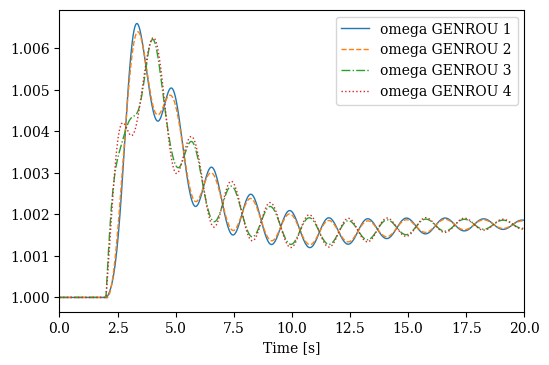

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [15]:
systems[0].TDS.plotter.plot(ss.GENROU.omega, latex=False)

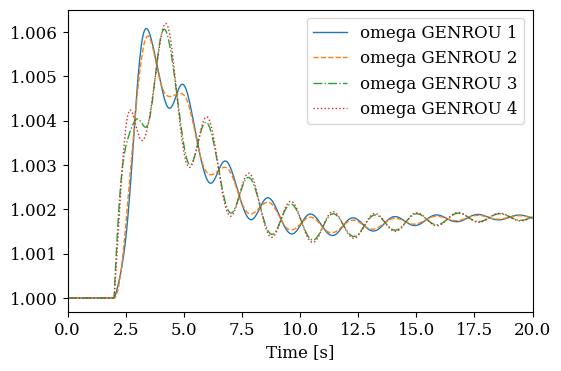

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [16]:
systems[2].TDS.plotter.plot(ss.GENROU.omega, latex=False)

In [17]:
!andes misc -C
!rm -rf batch_cases


    _           _         | Version 1.4.3.post11.dev0+g66add67d
   /_\  _ _  __| |___ ___ | Python 3.9.6 on Linux, 10/06/2021 09:05:50 AM
  / _ \| ' \/ _` / -_|_-< | 
 /_/ \_\_||_\__,_\___/__/ | This program comes with ABSOLUTELY NO WARRANTY.

No output file found in the working directory.
